# Rental Listing Inquiries
Kaggle: https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

In [78]:
import pandas as pd
import numpy as np

train_data = pd.read_json('train.json')
test_data = pd.read_json('test.json')

In [146]:
# Load train and test data
initial_train_features = train_data.columns.values

print '--- Train data ---'
print 'Unique listings: ', train_data['listing_id'].count()
print 'Number of features: ', len(initial_train_features)
print 'List of features: ',
for i in range(len(initial_train_features)):
    if i == len(initial_train_features) - 1:
        print initial_train_features[i]
    else:
        print initial_train_features[i]+',',

#train_data.head(20)

--- Train data ---
Unique listings:  49352
Number of features:  25
List of features:  bathrooms, bedrooms, building_id, created, description, display_address, features, interest_level, latitude, listing_id, longitude, manager_id, photos, price, street_address, price_bd_ratio, created_year, created_month, created_day, is_description, description_len, features_count, photos_count, building_id_updated, manager_id_updated


In [22]:
import re, string

big_list = []

pattern = re.compile('[\W_]+')

for item in train_data['features']:
    for feature in item:
        splitter_feature = re.split('\*|/', feature)
        for temp in splitter_feature:
            if not temp:
                continue
            temp = pattern.sub('', temp.lower())
            temp = ''.join(sorted(temp))
            if temp not in big_list:
                big_list.append(temp)

In [297]:
#print len(big_list)
#sorted(big_list)

In [147]:
initial_test_features = test_data.columns.values

print '--- Test data ---'
print 'Unique listings: ', test_data['listing_id'].count()
print 'Number of features: ', len(initial_test_features)
print 'List of features: ',
for i in range(len(initial_test_features)):
    if i == len(initial_test_features) - 1:
        print initial_test_features[i]
    else:
        print initial_test_features[i]+',',

#test_data.head()

--- Test data ---
Unique listings:  74659
Number of features:  24
List of features:  bathrooms, bedrooms, building_id, created, description, display_address, features, latitude, listing_id, longitude, manager_id, photos, price, street_address, price_bd_ratio, created_year, created_month, created_day, is_description, description_len, features_count, photos_count, building_id_updated, manager_id_updated


In [83]:
# Ration of NaN values
ratio = {}
for i in initial_train_features:
    k = 0
    for j in train_data[i].values:
        if j == 'NaN' or j == [] or j == '0' or j == '':
            k += 1
    ratio[i] = round(k / float(train_data[i].count()), 10)  
ratio

{u'bathrooms': 0.0,
 u'bedrooms': 0.0,
 u'building_id': 0.1678959313,
 u'created': 0.0,
 u'description': 0.0292997244,
 u'display_address': 0.0027354515,
 u'features': 0.0652050575,
 u'interest_level': 0.0,
 u'latitude': 0.0,
 u'listing_id': 0.0,
 u'longitude': 0.0,
 u'manager_id': 0.0,
 u'photos': 0.0732493111,
 u'price': 0.0,
 u'street_address': 0.000202626}

In [84]:
def update_features(df):
    # Cleaning and updating data
    df['created'] = pd.to_datetime(df['created'])

    # Creating new features
    df['price_bd_ratio'] = np.where(df['bedrooms'] == 0, 
                                            df['price'], 
                                            df['price'] / df['bedrooms'])
    df['created_year'] = df['created'].dt.year
    df['created_month'] = df['created'].dt.month
    df['created_day'] = df['created'].dt.day
    df['is_description'] = np.where(df['description'].str.len() < 50, 0, 1)
    df['description_len'] = df['description'].str.len()
    df['features_count'] = df['features'].str.len()
    df['photos_count'] = df['photos'].str.len()

    # Updated building id
    building_hash = {}
    bd_id = 0
    for item in df['building_id']:
        if item not in building_hash:
            building_hash[item] = bd_id
            bd_id += 1

    building_id_list = []
    for item in df['building_id']:
        building_id_list.append(building_hash[item])
    df['building_id_updated'] = building_id_list

    # Updated manager id
    manager_hash = {}
    mn_id = 0
    for manager in df['manager_id']:
        if manager not in manager_hash:
            manager_hash[manager] = mn_id
            mn_id += 1

    manager_id_list = []
    for manager in df['manager_id']:
        manager_id_list.append(manager_hash[manager])
    df['manager_id_updated'] = manager_id_list
    
    return df

In [311]:
listing_id = test_data['listing_id']

train_data = update_features(train_data)
test_data = update_features(test_data)
print type(test_data)
print type(listing_id)

listing_id

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


0         7142618
1         7210040
100       7103890
1000      7143442
100000    6860601
100001    6840081
100002    6922337
100003    6913616
100005    6937820
100006    6893933
100008    6832604
100009    6915282
10001     7127565
100010    6827899
100011    6934855
100012    6861826
100015    6871643
100017    6842542
100018    6934145
100019    6829365
10002     7167858
100021    6859483
100022    6861377
100023    6848960
100024    6918850
100025    6916867
100028    6895840
100029    6813539
10003     7116900
100031    6890328
           ...   
99957     6855560
99958     6816731
99959     6925764
9996      7139280
99962     6913068
99963     6828445
99967     6867865
99968     6820397
99969     6852197
9997      7122934
99970     6907838
99971     6865896
99972     6840250
99973     6926011
99974     6893100
99975     6867538
99976     6884360
99977     6903964
99978     6907851
9998      7211166
99981     6844290
99983     6947597
99985     6895423
99989     6812077
99990     

In [157]:
# Creating feature format for data

def feature_format(df, features):
    temp = pd.DataFrame()
    
    cl = df.columns.values.tolist()
    
    if 'interest_level' in cl:
        cl.insert(0, cl.pop(cl.index('interest_level')))
        df = df.reindex(columns=cl)
        temp = pd.DataFrame(df[features[0]])
        
    for i in range(1, len(features)):
        temp[features[i]] = df[features[i]]
    return np.array(temp)

In [158]:
features_ = ['interest_level', 'bathrooms', 'bedrooms', 'building_id', 'created', 
             'description', 'display_address', 'features', 'latitude', 'listing_id', 
             'longitude', 'manager_id', 'photos', 'price', 'street_address', 
             'price_bd_ratio', 'created_year', 'created_month', 'created_day', 
             'is_description', 'features_count', 'photos_count','building_id_updated',
             'manager_id_updated', 'description_len']
features_list = ['interest_level', 'bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 
                'price_bd_ratio', 'created_month', 'created_day', 'is_description', 'listing_id',
                'features_count', 'photos_count','building_id_updated', 'manager_id_updated',
                'description_len']

data = feature_format(train_data, features_list)
print data.shape

(49352, 16)


In [177]:
def labels_features_split(data, if_labels=True):
    labels = []
    features = []
    for i in data:
        if if_labels:
            labels.append(i[0])
            features.append(i[1:])
        else:
            features.append(i[:])
    return labels, features

labels, features = labels_features_split(data)

In [178]:
from sklearn.feature_selection import SelectKBest, f_classif

In [179]:
selection = SelectKBest(f_classif, k=1)
selection.fit(features, labels)

SelectKBest(k=1, score_func=<function f_classif at 0x1571fa230>)

In [180]:
from matplotlib import pyplot as plt

In [181]:
# Barchart function
%matplotlib inline 

def create_barchart(features_list, features_scores, desc, ylabel):
    features_scores = zip(features_list, features_scores)
    features_scores = sorted(features_scores, key=lambda x: x[1], reverse=True)

    features_sorted = [x[0] for x in features_scores]
    fl = np.array(features_sorted)
    sc = np.array([x[1] for x in features_scores])
    xs = np.arange(len(fl))

    plt.figure(figsize=(10, 8))
    plt.bar(xs, sc, alpha=0.5)
    plt.xticks(xs + 0.35, fl, rotation='vertical')
    plt.tight_layout()
    plt.ylabel(ylabel)
    plt.title('Feature Scores')
    plt.savefig(desc, bbox_inches='tight')
    plt.show()
    return features_sorted

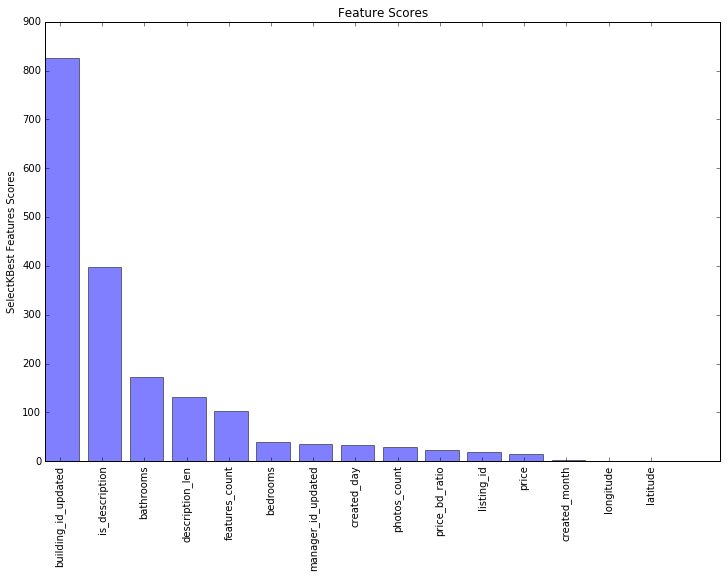

In [182]:
# Scores for features by SelectKBest

sorted_feature_list = create_barchart(features_list[1:], selection.scores_,
                                      'selectkbest_barchart.png', 'SelectKBest Features Scores')

In [183]:
pvals = []
for i in range(0, len(selection.scores_)):
    pval = -np.log10(selection.pvalues_[i])
    pvals.append(pval)
    print features_list[i + 1], '-> score:', selection.scores_[i], ', pvalue:', pvals[i]

bathrooms -> score: 171.685997624 , pvalue: 74.3040750094
bedrooms -> score: 39.2590686846 , pvalue: 17.0364473223
latitude -> score: 0.594402084793 , pvalue: 0.258142436177
longitude -> score: 0.663269677168 , pvalue: 0.288050489313
price -> score: 14.4625599418 , pvalue: 6.27916993956
price_bd_ratio -> score: 22.2287163635 , pvalue: 9.64946301388
created_month -> score: 1.51036417316 , pvalue: 0.655922751255
created_day -> score: 33.752580786 , pvalue: 14.6485428984
is_description -> score: 397.759516759 , pvalue: 171.367202156
listing_id -> score: 19.0858927767 , pvalue: 8.28569380794
features_count -> score: 102.926046301 , pvalue: 44.6072422252
photos_count -> score: 29.4632520196 , pvalue: 12.7880943052
building_id_updated -> score: 826.516239634 , pvalue: inf
manager_id_updated -> score: 34.3500508351 , pvalue: 14.9076632525
description_len -> score: 130.841050102 , pvalue: 56.6734179292


In [184]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def calc_recall_pres(feature_list, dataset, desc):
    current_feature_list = ['interest_level']
    precisions = []
    recalls = []

    features_num = []
    print 'Processing...'

    for i in range(0, len(feature_list)):
        current_feature_list.append(feature_list[i])
        data = feature_format(dataset, current_feature_list)

        labels, features = labels_features_split(data)
        features_train, features_test, labels_train, labels_test = \
                train_test_split(features, labels, test_size=0.33, random_state=42)

        clf = KNeighborsClassifier()
        clf.fit(features_train, labels_train)

        pred = clf.predict(features_test)
        
        #print current_feature_list
        #print clf.score(features_test, labels_test)
        precisions.append(metrics.precision_score(labels_test, pred, average='macro'))
        recalls.append(metrics.recall_score(labels_test, pred, average='macro'))
        features_num.append(len(current_feature_list))
        
    plt.figure()
    plt.scatter(np.array(features_num), np.array(precisions))
    plt.plot(np.array(features_num), np.array(precisions), label='Precision')
    plt.scatter(features_num, recalls, color='green')
    plt.plot(features_num, recalls, label='Recall')
    plt.legend(loc='upper right', shadow=True)
    plt.xlabel('Number of Features')
    plt.ylabel('Value')
    plt.title('Precision and Recall vs. Number of Features')
    plt.show()
    plt.savefig(desc)

Processing...


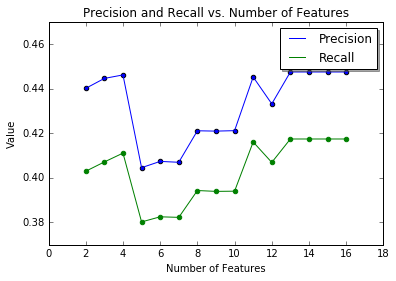

In [185]:
# Precision and recall scores for selected number of features
calc_recall_pres(sorted_feature_list, train_data, 'selectkbest_prec_recall.png')

In [186]:
from sklearn.feature_selection import RFE
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

In [187]:
from sklearn.svm import LinearSVC
from time import time

In [188]:
estimator = LinearSVC()

selector = RFE(estimator, n_features_to_select=5, step=1)
t1 = time()
selector = selector.fit(features, labels)
print 'RFE complete!', 'Training time: ', round(time() - t1, 3)

RFE complete! Training time:  339.151


Top ranked features: 
	price : 1
	price_bd_ratio : 1
	features_count : 1
	building_id_updated : 1
	description_len : 1


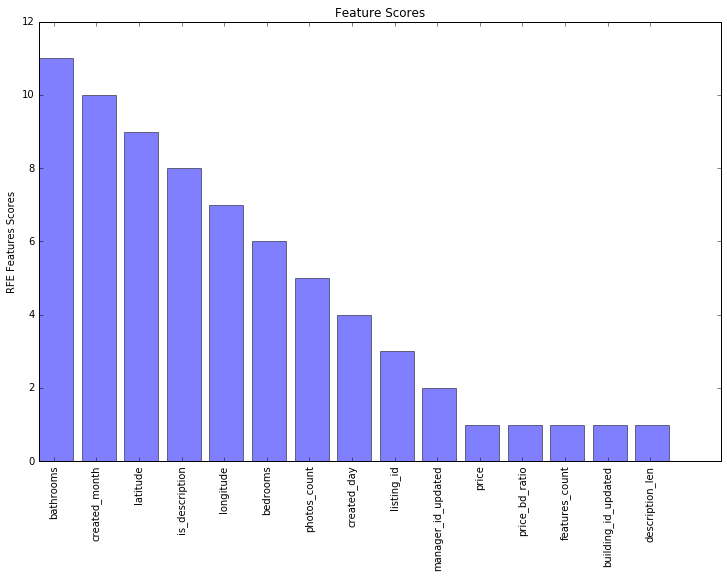

In [189]:
print 'Top ranked features: '
rank = selector.ranking_
for i in range(0, len(rank)):
    if rank[i] < 2:
        print '\t', features_list[i+1], ':', rank[i]

sorted_feature_list2 = create_barchart(features_list[1:], list(selector.ranking_),
                                       'rfe_barchart.png', 'RFE Features Scores')

Processing...


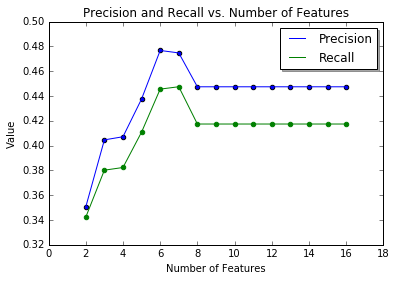

In [190]:
sorted_feature_list2.reverse()
calc_recall_pres(sorted_feature_list2, train_data, 'rfe_prec_recall.png')

In [191]:
#from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV

In [192]:
features_ = ['interest_level', 'bathrooms', 'bedrooms', 'building_id', 'created', 
             'description', 'display_address', 'features', 'latitude', 'listing_id', 
             'longitude', 'manager_id', 'photos', 'price', 'street_address', 
             'price_bd_ratio', 'created_year', 'created_month', 'created_day', 
             'is_description', 'features_count', 'photos_count','building_id_updated',
             'manager_id_updated']
selected_features_list_ = ['interest_level', 'building_id_updated']

selected_features_list = ['interest_level', 'bathrooms', 'bedrooms', 'latitude', 'longitude', 
                          'price_bd_ratio', 'created_day', 'is_description', 'listing_id',
                          'features_count', 'photos_count','building_id_updated', 'manager_id_updated',
                         'description_len']

In [227]:
clf_data = feature_format(train_data, selected_features_list)
data_sub = feature_format(test_data, selected_features_list)

clf_labels, clf_features = labels_features_split(clf_data)
labels_sub, features_sub = labels_features_split(data_sub, if_labels=False)

In [228]:
features_train, features_test, labels_train, labels_test = \
    model_selection.train_test_split(clf_features, clf_labels, test_size=0.4, random_state=42)

scaler = preprocessing.Normalizer().fit(features_train)
scaled_features_train = scaler.transform(features_train)
scaled_features_test = scaler.transform(features_test)

scaled_features_sub = scaler.transform(features_sub)

In [229]:
param_grid_rf = {'n_estimators': [50, 80, 100],
                 'max_features': ['auto', 'sqrt', 'log2'],
                 'min_samples_split': [15, 10, 25]}

In [230]:
#clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', leaf_size=10, algorithm='auto')
#clf = AdaBoostClassifier(n_estimators=50, algorithm='SAMME.R')
#clf = RandomForestClassifier(max_features='auto', min_samples_split=10, n_estimators=50)
#clf = SVC()
#clf = AdaBoostClassifier()

#svr = RandomForestClassifier()
#clf = GridSearchCV(svr, param_grid_rf)

In [231]:
clf = RandomForestClassifier(max_features='auto',
                             min_samples_split=25,
                             n_estimators=100,
                             criterion='entropy')

In [358]:
t1 = time()
print 'Start training...'
clf.fit(scaled_features_train, labels_train)
print 'Training complete!', 'Training time: ', round(time() - t1, 3)

print
print 'Predicting...'
pred = clf.predict(scaled_features_test)
pred_proba = clf.predict_proba(scaled_features_test)
print 'Prediction complete!'

Start training...
Training complete! Training time:  9.78

Predicting...
Prediction complete!


In [359]:
#print 'Best parameters: ', clf.best_params_
#print 'Best estimator: ', clf.best_estimator_

print 'Accuracy: ', clf.score(scaled_features_test, labels_test)
print 'Log loss: ', metrics.log_loss(labels_test, pred_proba)
print 'Average precision: ', metrics.precision_score(labels_test, pred, average='macro')
print 'Average recall: ', metrics.recall_score(labels_test, pred, average='macro')

Accuracy:  0.717390203131
Log loss:  0.633828152153
Average precision:  0.624444590867
Average recall:  0.422645713004


In [360]:
# Apply to submission data
pred_sub = clf.predict(scaled_features_sub)
pred_sub_proba = clf.predict_proba(scaled_features_sub)

In [361]:
classes = clf.classes_
print classes

[u'high' u'low' u'medium']


In [367]:
pred_df = pd.DataFrame(pred_sub_proba, columns=classes)
pred_df['listing_id'] = listing_id.values
pred_df = pred_df.reindex(columns=['listing_id', 'high', 'medium', 'low'])
pred_df.shape

(74659, 4)

In [366]:
pred_df.to_csv("submission.csv", index=False)

1. adaboost
Accuracy:  0.704984465757
Average precision:  0.580662714001
Average recall:  0.41457260709

2. randomforest
no price:
Accuracy:  0.716123803252
Average precision:  0.632190906366
Average recall:  0.422619485374

price:
Accuracy:  0.718200699053
Average precision:  0.614163188151
Average recall:  0.439975196956

(max_features='auto', min_samples_split=15, n_estimators=80, criterion='entropy')
Accuracy:  0.716061056329
Average precision:  0.617323321578
Average recall:  0.445681776606

(max_features='auto', min_samples_split=15, n_estimators=80)
Accuracy:  0.714034850736
Average precision:  0.612073862383
Average recall:  0.445454720936

3. kneighbors
Accuracy:  0.669998649196
Average precision:  0.470374013417
Average recall:  0.436490851589
4. linearsvc
Accuracy:  0.687964338782
Average precision:  0.229321446261
Average recall:  0.333333333333
5. svc
Accuracy:  0.687964338782
Average precision:  0.229321446261
Average recall:  0.333333333333
6. neural
Accuracy:  0.687964338782
Average precision:  0.229321446261
Average recall:  0.333333333333

1. robustscaler
Accuracy:  0.678846413616
Average precision:  0.477999451278
Average recall:  0.442697093516
2. standardscaler
Accuracy:  0.647372686749
Average precision:  0.411635009217
Average recall:  0.386056133269
3. normalizer
Accuracy:  0.669998649196
Average precision:  0.470374013417
Average recall:  0.436490851589

In [659]:
true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for p, truth in zip(pred, labels_test):
    if (p == 'low' and truth == 'low') or (p == 'medium' and truth == 'medium') or \
                                        (p == 'high' and truth == 'high'):
        true_positives += 1
    #elif 
    #print p, truth

print true_positives/float(len(pred))
print true_positives, false_positives
precision = 1.0*true_positives/(true_positives+false_positives)

0.715921179272
14133 0
